# Exercise 03 : Bar charts

## Imports

In [1]:
import pandas as pd
import sqlite3

## Create a graph like in subject:
- analyze only the users and not the admins
- the fontsize and the figsize remain the same
- for each hour, calculate the average number of commits on working days and on weekends (if there were no commits in an hour, do not use it to calculate the average) use these values for your graph, for example: Mon, 17-18: 5 commits, Tue, 17-18: 6 commits, Wed, 17-18: 7 commits
- choose a palette that you really enjoy, you do not have to replicate it from the graph above

## Make a connection to the database

In [2]:
sql_con = sqlite3.connect('../data/checking-logs.sqlite.sqlite')

## Get commits

In [3]:
query = """
SELECT
    timestamp as datetime
FROM 
    checker
WHERE
    uid LIKE 'user_%'
"""
commits = pd.read_sql(query, sql_con, parse_dates=['datetime'])
commits

,datetime
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


## Calculating daytype

In [6]:
commits['daytype'] = commits['datetime'].dt.dayofweek.apply(lambda x: 'weekend' if x > 4 else 'working_day')
commits

,datetime,daytype
0,2020-04-17 05:19:02.744528,working_day
1,2020-04-17 05:22:35.249331,working_day
2,2020-04-17 05:22:45.549397,working_day
3,2020-04-17 05:34:14.691200,working_day
4,2020-04-17 05:34:24.422370,working_day
...,...,...
3202,2020-05-21 20:19:06.872761,working_day
3203,2020-05-21 20:22:41.785725,working_day
3204,2020-05-21 20:22:41.877806,working_day
3205,2020-05-21 20:37:00.129678,working_day


## Calculating average counts per hour

In [8]:
average_commits = commits.groupby(by=[commits['daytype'], 
                                      commits['datetime'].dt.hour,
                                      commits['datetime'].dt.date]).count()
average_commits.head(20)

datetime
daytype datetime datetime            
weekend 0        2020-04-19         2
                 2020-04-26         2
                 2020-05-10         2
        1        2020-05-10         6
        3        2020-04-25         1
        5        2020-04-19         2
        7        2020-04-18         1
                 2020-04-25        10
                 2020-04-26         2
                 2020-05-02         3
        8        2020-04-25         8
                 2020-04-26         6
                 2020-05-02         1
                 2020-05-03        13
        9        2020-04-19         2
                 2020-04-25         3
                 2020-05-02         2
                 2020-05-03        11
                 2020-05-10         2
                 2020-05-17         2

In [12]:
average_commits = commits.groupby(by=[commits['daytype'],
                                      commits['datetime'].dt.hour,
                                      commits['datetime'].dt.date]).count()

average_commits = average_commits.rename(columns={'datetime': 'count'})
average_commits = average_commits.groupby(level=['daytype', 'datetime']).mean()\
                                                               .swaplevel(i=0, j=1)\
                                                               .unstack()\
                                                               .droplevel(0, axis='columns')
average_commits.index.name = 'hour'
average_commits = average_commits.fillna(0)
average_commits

daytype,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,0.000000
3,1.000000,2.000000
5,2.000000,7.500000
6,0.000000,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


## Fill empty hours

In [13]:
for hour in range(0, 24):
    if hour not in average_commits.index.values:
        average_commits.loc[hour] = [0, 0]
        average_commits.sort_index(inplace=True)

## Creating graph

array([<AxesSubplot: title={'center': 'weekend'}, xlabel='hour'>,
       <AxesSubplot: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

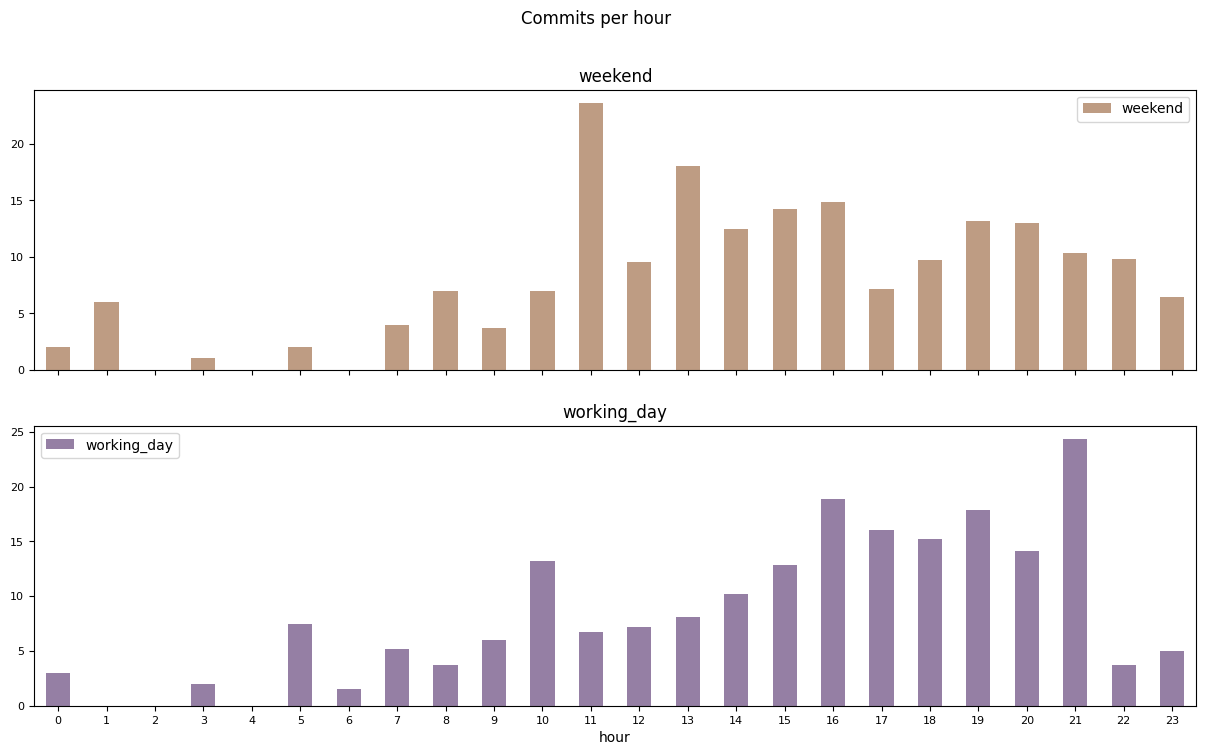

In [18]:
average_commits.plot.bar(subplots=True, 
                         sharex=True,
                         figsize=(15, 8),
                         fontsize=8,
                         title='Commits per hour',
                         colormap='PuOr',
                         alpha=0.5,
                         rot=0)

## Close the connection to the database

In [19]:
sql_con.close()

## Is the dynamic different on working days and weekends?
The answer is: yes;

More commits at weekends are made at 11-16 hours (afternoon).
More commits at working days are made at 16-21 hours (evening).